In [67]:
import numpy as np
import pandas as pd

import gensim
from gensim.models.doc2vec import Doc2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from nltk import ngrams

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Process input

In [7]:
all_info = pd.read_csv("/Users/yibingdu/Downloads/Winter Quarter/OHTAP/event_extents.csv")
all_info.head()

,Unnamed: 0,Interview,Number of event extents,Total word count,Event extents
0,0,BWOH_Adair_Christia,3,468,So I was the first volunteer secretary of the ...
1,1,BWOH_Adams_Kathleen,3,338,"But as I said, the Atlanta riot had occurred t..."
2,2,BWOH_Aiken_Harper_Rucker,2,415,"We walked to school, to Atlanta University eve..."
3,3,BWOH_Barnett_Etta,1,818,REH: So this would be a time of assessment rea...
4,4,BWOH_Duster_Alfreda,3,162,AD: And he married a very attractive woman who...


In [11]:
content = all_info["Event extents"]
content

0      So I was the first volunteer secretary of the ...
1      But as I said, the Atlanta riot had occurred t...
2      We walked to school, to Atlanta University eve...
3      REH: So this would be a time of assessment rea...
4      AD: And he married a very attractive woman who...
                             ...                        
486    DUNHAM: I definitely want to hear about your r...
487                                             outrage.
488    But just thinking, and again I hadn't thought ...
489    Did you have student athletes or did you hear ...
490    I knew someone who was raped by her father bec...
Name: Event extents, Length: 491, dtype: object

# Bag-of-N-grams / tf-idf

In [36]:
vectorizer = TfidfVectorizer(min_df=10, max_df=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(content)
vocab = vectorizer.get_feature_names()

In [37]:
def find_similar(statement):
    i = all_info[all_info["Event extents"] == statement].index.tolist()[0]
    cosine_similarities = linear_kernel(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    cosine_similarities = list(enumerate(cosine_similarities))
    cosine_similarities.pop(i)
    most_similar, similarity = max(cosine_similarities, key=lambda t:t[1])
    print("Original claim:\n", statement)
    print("==== ==== ==== ====")
    print("Most similar to:\n", content[most_similar])

text = content[0] # choose 
find_similar(text)

Original claim:
 So I was the first volunteer secretary of the branch here. Well, we had some pretty strong cases, cases like the DiMarco-Bob White case. Most of the cases were rape cases where white people used to become dissatisfied and disgruntled about a thing. The best way they could do, some white woman would holler that she'd been raped by a Negro or ventured to rape, or something like that, and of course that meant a burned or lynched Negro. And so this happened down at Conroe. But we were able to get a lawyer - this was one of NAACP's first projects - and a lawyer that won that case in our favor. And the day of the trial when he was declared innocent and turned loose, they shot him right in the jail house, I mean right in the courthouse down in Conroe, that's in Montgomery County. Well, those things were so exciting to me, I did not know that people could be treated like people in Houston were being treated. Not only in cases like that, but in jail, prisoners generally, why, t

# k-means clustering (of tf-idf)

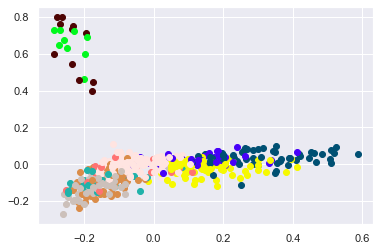

In [72]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2

clustering_model = KMeans(n_clusters=num_clusters, max_iter=max_iterations)

labels = clustering_model.fit_predict(tfidf_matrix)
X = tfidf_matrix.todense()
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# LDA

In [ ]:
# implemented with R package stm (Structural Topic Modeling) instead

# doc2vec

In [27]:
TaggedDocument = gensim.models.doc2vec.TaggedDocument
text = []
for i, sent in enumerate(content):
    if isinstance(sent, str):
        word_list = sent.split()
        document = TaggedDocument(word_list, tags=[i])
        text.append(document)

In [28]:
model = Doc2Vec(text, min_count=1, window=3, vector_size=300, sample=1e-3, negative=5, workers=4)
model.train(text, total_examples=model.corpus_count, epochs=10)

In [35]:
def find_doc2vec_similar_texts(test_text):
    inferred_vector = model.infer_vector(doc_words=test_text.split(), alpha=0.025, steps=500)
    sims = model.docvecs.most_similar([inferred_vector], topn=10)
    print("Original: ")
    print(test_text)
    for count, sim in sims:
        sentence = content[count]
        output = ""
        for word in sentence:
            output = output + str(word)
        print("==== ==== ==== ====")
        print(output)
        print(sim)

# example
find_doc2vec_similar_texts(content[0])

Original: 
So I was the first volunteer secretary of the branch here. Well, we had some pretty strong cases, cases like the DiMarco-Bob White case. Most of the cases were rape cases where white people used to become dissatisfied and disgruntled about a thing. The best way they could do, some white woman would holler that she'd been raped by a Negro or ventured to rape, or something like that, and of course that meant a burned or lynched Negro. And so this happened down at Conroe. But we were able to get a lawyer - this was one of NAACP's first projects - and a lawyer that won that case in our favor. And the day of the trial when he was declared innocent and turned loose, they shot him right in the jail house, I mean right in the courthouse down in Conroe, that's in Montgomery County. Well, those things were so exciting to me, I did not know that people could be treated like people in Houston were being treated. Not only in cases like that, but in jail, prisoners generally, why, they wo